The original version of reconstruction script, from Kobe

With tip loss and contour loss of the original frame.

Without motion model loss.

In [1]:
'''
File used to run optimization on the catheter parameters. 
Uses Adam optimizer. 
'''
import sys
# from turtle import pd

sys.path.append('..')

# import os
import numpy as np

# import transforms
# import bezier_interspace_transforms
# sys.path.insert(1, '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts')
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')
# from bezier_set import BezierSet
# import camera_settings

import torch

# import open3d as o3d

import cv2
import matplotlib.pyplot as plt

# import pdb

from test_reconst_v2 import ConstructionBezier
# from blender_catheter import BlenderRenderCatheter
# from diff_render_catheter import DiffRenderCatheter
from test_loss_define_v2 import ChamferLossWholeImage, ContourChamferLoss, \
    TipChamferLoss, BoundaryPointChamferLoss, TipDistanceLoss, BoundaryPointDistanceLoss, \
    GenerateRefData

# import pytorch3d

import torch.nn as nn
# import torch.nn.functional as F

# import matplotlib.cm as colormap

# from tqdm.notebook import tqdm
from tqdm.auto import tqdm


class CatheterOptimizeModel(nn.Module): 
    '''
    This class is used to optimize the catheter parameters.
    '''
    def __init__(self, p_start, para_init, image_ref, gpu_or_cpu): 
        '''
        This function initializes the catheter optimization model.

        Args:
            p_start (tensor): starting point of the catheter
            image_ref (numpy array): reference image to compare to
            gpu_or_cpu (str): either 'cuda' or 'cpu'
        '''
        super().__init__()

        ###========================================================
        ### 1) SETTING UP BEZIER CURVE CONSTRUCTION
        ###========================================================
        self.build_bezier = ConstructionBezier()
        self.build_bezier.to(gpu_or_cpu)
        self.build_bezier.loadRawImage(img_save_path)

        ###========================================================
        ### 2) SETTING UP LOSS FUNCTIONS
        ###========================================================
        # self.chamfer_loss_whole_image = ChamferLossWholeImage(device=gpu_or_cpu)
        # self.chamfer_loss_whole_image.to(gpu_or_cpu)
        self.contour_chamfer_loss = ContourChamferLoss(device=gpu_or_cpu)
        self.contour_chamfer_loss.to(gpu_or_cpu)
        # self.tip_chamfer_loss = TipChamferLoss(device=gpu_or_cpu)
        # self.tip_chamfer_loss.to(gpu_or_cpu)
        # self.boundary_point_chamfer_loss = BoundaryPointChamferLoss(device=gpu_or_cpu)
        # self.boundary_point_chamfer_loss.to(gpu_or_cpu)
        self.tip_distance_loss = TipDistanceLoss(device=gpu_or_cpu)
        self.tip_distance_loss.to(gpu_or_cpu)
        # self.boundary_point_distance_loss = BoundaryPointDistanceLoss(device=gpu_or_cpu)
        # self.boundary_point_distance_loss.to(gpu_or_cpu)

        # Declare self.tip_euclidean_distance_loss as a variable that'll hold a single numpy scalar value
        self.tip_euclidean_distance_loss = None


        ###========================================================
        ### 3) SETTING UP CURVE PARAMETERS
        ###========================================================

        # Straight Line for initial parameters
        # self.para_init = nn.Parameter(torch.from_numpy(
        #     np.array([0.02, 0.002, 0.0, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866],
        #              dtype=np.float32)).to(gpu_or_cpu),
        #                               requires_grad=True)

        self.p_start = p_start.to(gpu_or_cpu).detach()

        # self.para_init = nn.Parameter(torch.from_numpy(
        #     np.array([0.0365, 0.0036,  0.1202,  0.0056, -0.0166, 0.1645],
        #              dtype=np.float32)).to(gpu_or_cpu),
        #                               requires_grad=True)
        self.para_init = nn.Parameter(torch.from_numpy(para_init).to(gpu_or_cpu),
                                      requires_grad=True)

        

        image_ref = torch.from_numpy(image_ref.astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Generate reference data, so you don't need to generate it in every forward pass
        self.generate_ref_data = GenerateRefData(self.image_ref)
        ref_catheter_contour = self.generate_ref_data.get_raw_contour()
        self.register_buffer('ref_catheter_contour', ref_catheter_contour)
        ref_catheter_centerline = self.generate_ref_data.get_raw_centerline()
        self.register_buffer('ref_catheter_centerline', ref_catheter_centerline)




    def forward(self, save_img_path): 
        '''
        Function to run forward pass of the catheter optimization model.
        Creates catheter model, gets projection onto 2d image, and calculates loss.

        Args:
            save_img_path (str): path to save the projection image to
        '''

        # # Get 2d center line from reference image (using skeletonization)
        # centerline_ref = self.centerline_loss.get_raw_centerline(self.image_ref)
        # print("centerline_ref shape: ", centerline_ref.shape)
        # print("centerline_ref: ", centerline_ref)
        
        # # Plot the points in centerline_ref 
        # fig1, ax1 = plt.subplots()
        # ax1.plot(centerline_ref[:, 1], centerline_ref[:, 0])
        # ax1.set_title('centerline_ref')
        # ax1.set_xlim([0, 640])
        # ax1.set_ylim([480, 0])
        # plt.show()

        ###========================================================
        ### 1) RUNNING BEZIER CURVE CONSTRUCTION
        ###========================================================
        # Generate the Bezier curve cylinder mesh points
        self.build_bezier.getBezierCurveCylinder(self.p_start, self.para_init)

        # cylinder_mesh_points = self.build_bezier.cylinder_mesh_points
        # print("cylinder_mesh_points max value: ", torch.max(cylinder_mesh_points))

        # TEST LOSS TO SEE IF DIFFERENTIABLE UP TILL THIS POINT
        # find average distance of all the points in cylinder_mesh_points to (0, 0, 0)
        # loss = torch.mean(torch.norm(cylinder_mesh_points, dim=1))

        # Plot 3D Bezier Cylinder mesh points
        # self.build_bezier.plot3dBezierCylinder()

        # Get 2d projected Bezier Cylinder mesh points
        self.build_bezier.getCylinderMeshProjImg()


        # TEST LOSS TO SEE IF DIFFERENTIABLE UP TILL THIS POINT
        # find average distance of all the points in cylinder_mesh_points to (0, 0)
        # bezier_proj_img = self.build_bezier.bezier_proj_img
        # print("bezier_proj_img:" , bezier_proj_img)
        # print("Max value in bezier_proj_img: ", torch.max(bezier_proj_img))
        # print("average value in bezier_proj_img", torch.mean(bezier_proj_img))
        # loss = torch.mean(torch.norm(bezier_proj_img, dim=1))

        # Get 2d projected Bezier centerline (position) points
        self.build_bezier.getBezierProjImg()

        # TEST LOSS TO SEE IF DIFFERENTIABLE UP TILL THIS POINT
        # find average distance of all points in bezier_proj_centerline_img to (0, 0)
        # bezier_proj_centerline_img = self.build_bezier.bezier_proj_centerline_img
        # loss = torch.mean(torch.norm(bezier_proj_centerline_img, dim=1))

        # Plot 2D projected Bezier Cylinder mesh points
        # print("cylinder_mesh_points: ", self.build_bezier.cylinder_mesh_points)
        self.build_bezier.draw2DCylinderImage(self.image_ref, save_img_path)

        # TODO: add function to save image to file

        ###========================================================
        ### 4) Compute Loss using various Loss Functions
        ###========================================================
        # loss_whole_image = self.chamfer_loss_whole_image(self.build_bezier.bezier_proj_img, self.image_ref)
        # loss_contour = self.contour_chamfer_loss(self.build_bezier.bezier_proj_img, self.image_ref)
        # loss_tip = self.tip_chamfer_loss(self.build_bezier.bezier_proj_img, self.image_ref)
        # loss_boundary = self.boundary_point_chamfer_loss(self.build_bezier.bezier_proj_img, self.image_ref)
        # loss_tip_distance, self.tip_euclidean_distance_loss = self.tip_distance_loss(self.build_bezier.bezier_proj_centerline_img, self.image_ref)
        # loss_boundary_point_distance_loss = self.boundary_point_distance_loss(self.build_bezier.bezier_proj_img, self.image_ref)

        # loss_whole_image = self.chamfer_loss_whole_image(self.build_bezier.bezier_proj_img, self.image_ref)
        loss_contour = self.contour_chamfer_loss(self.build_bezier.bezier_proj_img.to(gpu_or_cpu), self.ref_catheter_contour.to(gpu_or_cpu))
        # loss_tip = self.tip_chamfer_loss(self.build_bezier.bezier_proj_img, self.ref_catheter_centerline)
        # loss_boundary = self.boundary_point_chamfer_loss(self.build_bezier.bezier_proj_img, self.ref_catheter_centerline)
        loss_tip_distance, self.tip_euclidean_distance_loss = self.tip_distance_loss(self.build_bezier.bezier_proj_centerline_img.to(gpu_or_cpu), self.ref_catheter_centerline.to(gpu_or_cpu))
        # loss_boundary_point_distance_loss = self.boundary_point_distance_loss(self.build_bezier.bezier_proj_img, self.ref_catheter_centerline)


        weight = torch.tensor([1.0, 1.0])
        loss = loss_contour * weight[0] + loss_tip_distance * weight[1]


        print("-----------------------------------------------------------------")
        print("loss_contour: ", loss_contour)
        # print("loss_tip: ", loss_tip)
        # print("loss_boundary: ", loss_boundary)
        print("loss_tip_distance: ", loss_tip_distance)
        # print("loss_boundary_point_distance_loss: ", loss_boundary_point_distance_loss)
        print("loss: ", loss)
        print("-----------------------------------------------------------------")


        # TODO: Plot the loss

        return loss






Camera Intrinsics:
[[883.00220751   0.         320.        ]
 [  0.         883.00220751 240.        ]
 [  0.           0.           1.        ]]
Camera Extrinsics:
[[-1.00000000e+00 -1.22464680e-16  1.49975978e-32  0.00000000e+00]
 [-1.22464680e-16  1.00000000e+00 -1.22464680e-16  0.00000000e+00]
 [ 0.00000000e+00 -1.22464680e-16 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


d:\Programs\miniconda3\envs\catheter\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_gt_params(cc_specs_path):
    """
    The order of gt: [p_start, p_end, c1, c2]
    """
    
    para_gt_np = np.load(cc_specs_path)
    matrix = np.squeeze(para_gt_np)
    c1 = matrix[2]
    c2 = matrix[3]
    p_start = matrix[0]
    p_end = matrix[1]
    p_mid = 3/4 * (c1 + p_end/3)
    p1 = 2*p_mid - 0.5*p_start - 0.5*p_end
    result_vector = np.concatenate((p1, p_end))
    return result_vector 

In [3]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 10, 255, cv2.THRESH_BINARY)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0
-----------------------------------------------------------------
loss_contour:  tensor(69079267.4932, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(61674.5805, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(69140942.0737, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   1%|          | 1/100 [00:01<02:04,  1.26s/it, loss=6.91e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 32959875072.0
Parameter: para_init, Updated Value: tensor([ 0.0240, -0.0200,  0.5260,  0.2100, -0.3600,  0.5900], device='cuda:0')
Loss:  69140942.07366124

loop_id:  1
-----------------------------------------------------------------
loss_contour:  tensor(93587702.6035, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(62865.8750, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(93650568.4785, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   2%|▏         | 2/100 [00:02<01:42,  1.04s/it, loss=9.37e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 196850548736.0
Parameter: para_init, Updated Value: tensor([ 0.0160, -0.0299,  0.5161,  0.2183, -0.3518,  0.5964], device='cuda:0')
Loss:  93650568.4784896

loop_id:  2
-----------------------------------------------------------------
loss_contour:  tensor(82929994.2951, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(58840.6987, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(82988834.9938, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   3%|▎         | 3/100 [00:03<01:47,  1.10s/it, loss=8.3e+7] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 34702262272.0
Parameter: para_init, Updated Value: tensor([ 0.0110, -0.0375,  0.5165,  0.2230, -0.3475,  0.5967], device='cuda:0')
Loss:  82988834.99383381

loop_id:  3
-----------------------------------------------------------------
loss_contour:  tensor(59532940.8063, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(58079.5033, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(59591020.3097, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   4%|▍         | 4/100 [00:04<01:50,  1.16s/it, loss=5.96e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 204846039040.0
Parameter: para_init, Updated Value: tensor([ 0.0039, -0.0404,  0.5109,  0.2300, -0.3407,  0.6025], device='cuda:0')
Loss:  59591020.30965601

loop_id:  4
-----------------------------------------------------------------
loss_contour:  tensor(35967393.8755, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(55140.7531, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(36022534.6287, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   5%|▌         | 5/100 [00:05<01:59,  1.26s/it, loss=3.6e+7] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 12168246272.0
Parameter: para_init, Updated Value: tensor([-0.0018, -0.0433,  0.5064,  0.2356, -0.3354,  0.6069], device='cuda:0')
Loss:  36022534.62865436

loop_id:  5
-----------------------------------------------------------------
loss_contour:  tensor(33809643.7527, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(53116.0155, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(33862759.7682, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   6%|▌         | 6/100 [00:07<02:10,  1.39s/it, loss=3.39e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1289489792.0
Parameter: para_init, Updated Value: tensor([-0.0067, -0.0458,  0.5022,  0.2404, -0.3308,  0.6106], device='cuda:0')
Loss:  33862759.76815047

loop_id:  6
-----------------------------------------------------------------
loss_contour:  tensor(17310951.5939, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(51545.1864, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(17362496.7802, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   7%|▋         | 7/100 [00:09<02:22,  1.53s/it, loss=1.74e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1215514880.0
Parameter: para_init, Updated Value: tensor([-0.0110, -0.0480,  0.4985,  0.2446, -0.3267,  0.6139], device='cuda:0')
Loss:  17362496.78024474

loop_id:  7
-----------------------------------------------------------------
loss_contour:  tensor(18982544.8281, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(50254.7900, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(19032799.6181, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   8%|▊         | 8/100 [00:11<02:36,  1.70s/it, loss=1.9e+7] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 686180992.0
Parameter: para_init, Updated Value: tensor([-0.0148, -0.0500,  0.4951,  0.2483, -0.3232,  0.6168], device='cuda:0')
Loss:  19032799.618102465

loop_id:  8
-----------------------------------------------------------------
loss_contour:  tensor(60832175.4812, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(49217.1113, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(60881392.5925, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   9%|▉         | 9/100 [00:13<02:50,  1.88s/it, loss=6.09e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 37513539584.0
Parameter: para_init, Updated Value: tensor([-0.0175, -0.0530,  0.4946,  0.2505, -0.3217,  0.6165], device='cuda:0')
Loss:  60881392.59254996

loop_id:  9
-----------------------------------------------------------------
loss_contour:  tensor(22717424.6843, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(49457.1083, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(22766881.7926, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  10%|█         | 10/100 [00:16<03:03,  2.04s/it, loss=2.28e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 10750525440.0
Parameter: para_init, Updated Value: tensor([-0.0202, -0.0554,  0.4933,  0.2527, -0.3200,  0.6170], device='cuda:0')
Loss:  22766881.792611197

loop_id:  10
-----------------------------------------------------------------
loss_contour:  tensor(33633964.1975, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(49377.9931, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(33683342.1907, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  11%|█         | 11/100 [00:18<03:20,  2.25s/it, loss=3.37e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 20548859904.0
Parameter: para_init, Updated Value: tensor([-0.0228, -0.0568,  0.4906,  0.2553, -0.3175,  0.6190], device='cuda:0')
Loss:  33683342.19066031

loop_id:  11
-----------------------------------------------------------------
loss_contour:  tensor(50908286.7495, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(48732.3022, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(50957019.0517, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  12%|█▏        | 12/100 [00:22<03:43,  2.54s/it, loss=5.1e+7] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 48133316608.0
Parameter: para_init, Updated Value: tensor([-0.0259, -0.0567,  0.4855,  0.2588, -0.3135,  0.6235], device='cuda:0')
Loss:  50957019.0517024

loop_id:  12
-----------------------------------------------------------------
loss_contour:  tensor(12147920.6437, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(47202.0216, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(12195122.6654, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  13%|█▎        | 13/100 [00:25<03:57,  2.73s/it, loss=1.22e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 453036608.0
Parameter: para_init, Updated Value: tensor([-0.0287, -0.0566,  0.4810,  0.2620, -0.3098,  0.6275], device='cuda:0')
Loss:  12195122.66536164

loop_id:  13
-----------------------------------------------------------------
loss_contour:  tensor(46416307.6288, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45925.0555, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(46462232.6843, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  14%|█▍        | 14/100 [00:28<04:10,  2.92s/it, loss=4.65e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 58344714240.0
Parameter: para_init, Updated Value: tensor([-0.0304, -0.0585,  0.4807,  0.2632, -0.3094,  0.6270], device='cuda:0')
Loss:  46462232.68434192

loop_id:  14
-----------------------------------------------------------------
loss_contour:  tensor(47827774.4175, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(46297.8675, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(47874072.2850, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  15%|█▌        | 15/100 [00:32<04:22,  3.09s/it, loss=4.79e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 83727630336.0
Parameter: para_init, Updated Value: tensor([-0.0306, -0.0623,  0.4839,  0.2622, -0.3119,  0.6233], device='cuda:0')
Loss:  47874072.28501032

loop_id:  15
-----------------------------------------------------------------
loss_contour:  tensor(17508364.4393, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(47828.9226, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(17556193.3620, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  16%|█▌        | 16/100 [00:35<04:35,  3.29s/it, loss=1.76e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2625203712.0
Parameter: para_init, Updated Value: tensor([-0.0308, -0.0658,  0.4869,  0.2612, -0.3143,  0.6197], device='cuda:0')
Loss:  17556193.361953143

loop_id:  16
-----------------------------------------------------------------
loss_contour:  tensor(13546072.6846, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(49311.7557, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(13595384.4403, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  17%|█▋        | 17/100 [00:39<04:45,  3.44s/it, loss=1.36e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1032480256.0
Parameter: para_init, Updated Value: tensor([-0.0309, -0.0690,  0.4896,  0.2603, -0.3166,  0.6165], device='cuda:0')
Loss:  13595384.440256342

loop_id:  17
-----------------------------------------------------------------
loss_contour:  tensor(9828490.2840, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(50722.8874, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(9879213.1714, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  18%|█▊        | 18/100 [00:43<04:51,  3.55s/it, loss=9.88e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 193702752.0
Parameter: para_init, Updated Value: tensor([-0.0310, -0.0719,  0.4921,  0.2595, -0.3186,  0.6135], device='cuda:0')
Loss:  9879213.17135327

loop_id:  18
-----------------------------------------------------------------
loss_contour:  tensor(11266853.9018, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(52048.5351, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(11318902.4369, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  19%|█▉        | 19/100 [00:47<05:02,  3.74s/it, loss=1.13e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 116744192.0
Parameter: para_init, Updated Value: tensor([-0.0312, -0.0746,  0.4943,  0.2587, -0.3204,  0.6108], device='cuda:0')
Loss:  11318902.436866492

loop_id:  19
-----------------------------------------------------------------
loss_contour:  tensor(15877055.4682, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(53288.5923, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(15930344.0605, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  20%|██        | 20/100 [00:51<05:12,  3.90s/it, loss=1.59e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3482020096.0
Parameter: para_init, Updated Value: tensor([-0.0312, -0.0771,  0.4965,  0.2579, -0.3223,  0.6081], device='cuda:0')
Loss:  15930344.06053735

loop_id:  20
-----------------------------------------------------------------
loss_contour:  tensor(18683631.6691, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(54527.6901, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(18738159.3592, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  21%|██        | 21/100 [00:56<05:22,  4.08s/it, loss=1.87e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3220947712.0
Parameter: para_init, Updated Value: tensor([-0.0313, -0.0793,  0.4983,  0.2573, -0.3238,  0.6059], device='cuda:0')
Loss:  18738159.359188657

loop_id:  21
-----------------------------------------------------------------
loss_contour:  tensor(23422243.9941, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(55603.0468, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(23477847.0409, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  22%|██▏       | 22/100 [01:01<05:36,  4.31s/it, loss=2.35e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7456303104.0
Parameter: para_init, Updated Value: tensor([-0.0313, -0.0815,  0.5003,  0.2565, -0.3255,  0.6034], device='cuda:0')
Loss:  23477847.040887307

loop_id:  22
-----------------------------------------------------------------
loss_contour:  tensor(10512170.3291, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(56800.9368, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(10568971.2660, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  23%|██▎       | 23/100 [01:06<05:51,  4.57s/it, loss=1.06e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 321446080.0
Parameter: para_init, Updated Value: tensor([-0.0313, -0.0835,  0.5020,  0.2558, -0.3271,  0.6012], device='cuda:0')
Loss:  10568971.265974902

loop_id:  23
-----------------------------------------------------------------
loss_contour:  tensor(9920138.4255, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(57909.3461, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(9978047.7717, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  24%|██▍       | 24/100 [01:11<05:58,  4.72s/it, loss=9.98e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 510072672.0
Parameter: para_init, Updated Value: tensor([-0.0313, -0.0853,  0.5036,  0.2551, -0.3285,  0.5992], device='cuda:0')
Loss:  9978047.771683829

loop_id:  24
-----------------------------------------------------------------
loss_contour:  tensor(24808913.4343, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(58925.6680, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(24867839.1022, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  25%|██▌       | 25/100 [01:16<06:07,  4.90s/it, loss=2.49e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5159930368.0
Parameter: para_init, Updated Value: tensor([-0.0312, -0.0870,  0.5053,  0.2544, -0.3300,  0.5970], device='cuda:0')
Loss:  24867839.10224471

loop_id:  25
-----------------------------------------------------------------
loss_contour:  tensor(11828943.7513, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(60032.8699, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(11888976.6212, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  26%|██▌       | 26/100 [01:22<06:19,  5.12s/it, loss=1.19e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1409064192.0
Parameter: para_init, Updated Value: tensor([-0.0311, -0.0886,  0.5067,  0.2537, -0.3313,  0.5951], device='cuda:0')
Loss:  11888976.621178417

loop_id:  26
-----------------------------------------------------------------
loss_contour:  tensor(16446719.3087, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(61016.1147, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(16507735.4234, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  27%|██▋       | 27/100 [01:28<06:24,  5.27s/it, loss=1.65e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2990600704.0
Parameter: para_init, Updated Value: tensor([-0.0311, -0.0900,  0.5078,  0.2532, -0.3323,  0.5936], device='cuda:0')
Loss:  16507735.42341815

loop_id:  27
-----------------------------------------------------------------
loss_contour:  tensor(26529092.2027, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(61824.2151, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(26590916.4179, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  28%|██▊       | 28/100 [01:33<06:30,  5.43s/it, loss=2.66e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7737289728.0
Parameter: para_init, Updated Value: tensor([-0.0312, -0.0912,  0.5082,  0.2531, -0.3329,  0.5928], device='cuda:0')
Loss:  26590916.41788082

loop_id:  28
-----------------------------------------------------------------
loss_contour:  tensor(23919374.7365, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(62290.5598, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(23981665.2963, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  29%|██▉       | 29/100 [01:39<06:37,  5.60s/it, loss=2.4e+7] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 17230131200.0
Parameter: para_init, Updated Value: tensor([-0.0317, -0.0921,  0.5073,  0.2535, -0.3325,  0.5934], device='cuda:0')
Loss:  23981665.296250407

loop_id:  29
-----------------------------------------------------------------
loss_contour:  tensor(18867640.3151, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(62088.2437, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(18929728.5589, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  30%|███       | 30/100 [01:46<06:46,  5.81s/it, loss=1.89e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4151741440.0
Parameter: para_init, Updated Value: tensor([-0.0321, -0.0928,  0.5062,  0.2541, -0.3320,  0.5943], device='cuda:0')
Loss:  18929728.558870602

loop_id:  30
-----------------------------------------------------------------
loss_contour:  tensor(12931752.6411, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(61753.8795, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(12993506.5206, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  31%|███       | 31/100 [01:52<06:55,  6.02s/it, loss=1.3e+7] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2681479936.0
Parameter: para_init, Updated Value: tensor([-0.0326, -0.0934,  0.5050,  0.2547, -0.3314,  0.5953], device='cuda:0')
Loss:  12993506.520618524

loop_id:  31
-----------------------------------------------------------------
loss_contour:  tensor(12735010.1072, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(61352.0905, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(12796362.1976, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  32%|███▏      | 32/100 [01:59<07:03,  6.23s/it, loss=1.28e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1558137216.0
Parameter: para_init, Updated Value: tensor([-0.0330, -0.0940,  0.5037,  0.2553, -0.3307,  0.5963], device='cuda:0')
Loss:  12796362.197617501

loop_id:  32
-----------------------------------------------------------------
loss_contour:  tensor(10359812.2035, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(60930.8442, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(10420743.0478, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  33%|███▎      | 33/100 [02:06<07:14,  6.48s/it, loss=1.04e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 945245184.0
Parameter: para_init, Updated Value: tensor([-0.0335, -0.0945,  0.5024,  0.2560, -0.3301,  0.5973], device='cuda:0')
Loss:  10420743.047753707

loop_id:  33
-----------------------------------------------------------------
loss_contour:  tensor(14255856.1659, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(60514.7700, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(14316370.9359, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  34%|███▍      | 34/100 [02:13<07:14,  6.59s/it, loss=1.43e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1127477376.0
Parameter: para_init, Updated Value: tensor([-0.0339, -0.0950,  0.5014,  0.2565, -0.3296,  0.5981], device='cuda:0')
Loss:  14316370.9359016

loop_id:  34
-----------------------------------------------------------------
loss_contour:  tensor(18718753.1285, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(60185.7844, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(18778938.9129, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  35%|███▌      | 35/100 [02:20<07:17,  6.74s/it, loss=1.88e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4487337984.0
Parameter: para_init, Updated Value: tensor([-0.0341, -0.0955,  0.5007,  0.2567, -0.3294,  0.5985], device='cuda:0')
Loss:  18778938.912912827

loop_id:  35
-----------------------------------------------------------------
loss_contour:  tensor(8300194.6430, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(60074.5851, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(8360269.2282, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  36%|███▌      | 36/100 [02:27<07:20,  6.89s/it, loss=8.36e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 392180608.0
Parameter: para_init, Updated Value: tensor([-0.0344, -0.0960,  0.5001,  0.2570, -0.3292,  0.5988], device='cuda:0')
Loss:  8360269.228158985

loop_id:  36
-----------------------------------------------------------------
loss_contour:  tensor(10105945.7469, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(59957.9052, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(10165903.6521, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  37%|███▋      | 37/100 [02:35<07:24,  7.06s/it, loss=1.02e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1078484224.0
Parameter: para_init, Updated Value: tensor([-0.0346, -0.0964,  0.4994,  0.2573, -0.3289,  0.5992], device='cuda:0')
Loss:  10165903.65208929

loop_id:  37
-----------------------------------------------------------------
loss_contour:  tensor(11390194.7347, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(59806.6718, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(11450001.4065, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  38%|███▊      | 38/100 [02:42<07:31,  7.29s/it, loss=1.15e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 90557128.0
Parameter: para_init, Updated Value: tensor([-0.0348, -0.0968,  0.4988,  0.2576, -0.3287,  0.5996], device='cuda:0')
Loss:  11450001.406527193

loop_id:  38
-----------------------------------------------------------------
loss_contour:  tensor(12967284.5780, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(59670.5437, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(13026955.1217, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  39%|███▉      | 39/100 [02:50<07:36,  7.49s/it, loss=1.3e+7] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2186011392.0
Parameter: para_init, Updated Value: tensor([-0.0350, -0.0972,  0.4983,  0.2577, -0.3286,  0.5997], device='cuda:0')
Loss:  13026955.121725544

loop_id:  39
-----------------------------------------------------------------
loss_contour:  tensor(21286880.5194, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(59645.2657, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(21346525.7851, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  40%|████      | 40/100 [02:59<07:44,  7.74s/it, loss=2.13e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7898140672.0
Parameter: para_init, Updated Value: tensor([-0.0353, -0.0974,  0.4972,  0.2582, -0.3280,  0.6006], device='cuda:0')
Loss:  21346525.785088558

loop_id:  40
-----------------------------------------------------------------
loss_contour:  tensor(10798103.2139, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(59270.9041, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(10857374.1181, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  41%|████      | 41/100 [03:07<07:50,  7.97s/it, loss=1.09e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 157195056.0
Parameter: para_init, Updated Value: tensor([-0.0356, -0.0977,  0.4961,  0.2586, -0.3275,  0.6014], device='cuda:0')
Loss:  10857374.11805192

loop_id:  41
-----------------------------------------------------------------
loss_contour:  tensor(17493569.8692, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(58939.9976, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(17552509.8668, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  42%|████▏     | 42/100 [03:16<07:57,  8.24s/it, loss=1.76e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3149419520.0
Parameter: para_init, Updated Value: tensor([-0.0359, -0.0979,  0.4948,  0.2591, -0.3269,  0.6025], device='cuda:0')
Loss:  17552509.866821796

loop_id:  42
-----------------------------------------------------------------
loss_contour:  tensor(12081347.9667, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(58498.7018, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(12139846.6685, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  43%|████▎     | 43/100 [03:25<08:02,  8.47s/it, loss=1.21e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 345395808.0
Parameter: para_init, Updated Value: tensor([-0.0362, -0.0981,  0.4936,  0.2595, -0.3263,  0.6034], device='cuda:0')
Loss:  12139846.668509753

loop_id:  43
-----------------------------------------------------------------
loss_contour:  tensor(14080825.9137, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(58086.8804, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(14138912.7942, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  44%|████▍     | 44/100 [03:34<07:59,  8.57s/it, loss=1.41e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 634853632.0
Parameter: para_init, Updated Value: tensor([-0.0364, -0.0982,  0.4924,  0.2600, -0.3257,  0.6044], device='cuda:0')
Loss:  14138912.794166889

loop_id:  44
-----------------------------------------------------------------
loss_contour:  tensor(10897716.3952, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(57687.4757, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(10955403.8709, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  45%|████▌     | 45/100 [03:43<07:56,  8.66s/it, loss=1.1e+7] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 697933184.0
Parameter: para_init, Updated Value: tensor([-0.0367, -0.0984,  0.4911,  0.2604, -0.3251,  0.6053], device='cuda:0')
Loss:  10955403.870899105

loop_id:  45
-----------------------------------------------------------------
loss_contour:  tensor(12354866.0541, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(57295.3419, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(12412161.3961, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  46%|████▌     | 46/100 [03:52<07:52,  8.75s/it, loss=1.24e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 457862496.0
Parameter: para_init, Updated Value: tensor([-0.0370, -0.0985,  0.4900,  0.2608, -0.3245,  0.6062], device='cuda:0')
Loss:  12412161.396079058

loop_id:  46
-----------------------------------------------------------------
loss_contour:  tensor(10353417.3289, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(56921.5970, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(10410338.9259, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  47%|████▋     | 47/100 [04:01<07:49,  8.86s/it, loss=1.04e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 322795680.0
Parameter: para_init, Updated Value: tensor([-0.0372, -0.0987,  0.4889,  0.2612, -0.3240,  0.6071], device='cuda:0')
Loss:  10410338.925861763

loop_id:  47
-----------------------------------------------------------------
loss_contour:  tensor(10575252.7121, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(56570.2873, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(10631822.9995, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  48%|████▊     | 48/100 [04:10<07:47,  9.00s/it, loss=1.06e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 581569600.0
Parameter: para_init, Updated Value: tensor([-0.0374, -0.0988,  0.4879,  0.2615, -0.3236,  0.6078], device='cuda:0')
Loss:  10631822.99947584

loop_id:  48
-----------------------------------------------------------------
loss_contour:  tensor(7317961.7377, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(56282.8411, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(7374244.5788, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  49%|████▉     | 49/100 [04:20<07:51,  9.24s/it, loss=7.37e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 54367248.0
Parameter: para_init, Updated Value: tensor([-0.0376, -0.0989,  0.4870,  0.2618, -0.3231,  0.6084], device='cuda:0')
Loss:  7374244.578827091

loop_id:  49
-----------------------------------------------------------------
loss_contour:  tensor(15314672.5296, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(56023.6853, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(15370696.2149, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  50%|█████     | 50/100 [04:30<07:54,  9.50s/it, loss=1.54e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1805883520.0
Parameter: para_init, Updated Value: tensor([-0.0378, -0.0990,  0.4859,  0.2622, -0.3227,  0.6092], device='cuda:0')
Loss:  15370696.214877075

loop_id:  50
-----------------------------------------------------------------
loss_contour:  tensor(1.0089e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(55700.6709, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(1.0095e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  51%|█████     | 51/100 [04:40<07:56,  9.72s/it, loss=1.01e+8]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 933866897408.0
Parameter: para_init, Updated Value: tensor([-0.0446, -0.0929,  0.4788,  0.2692, -0.3156,  0.6163], device='cuda:0')
Loss:  100946533.62293926

loop_id:  51
-----------------------------------------------------------------
loss_contour:  tensor(18500079.8941, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(53321.1748, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(18553401.0689, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  52%|█████▏    | 52/100 [04:50<07:52,  9.84s/it, loss=1.86e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3702471680.0
Parameter: para_init, Updated Value: tensor([-0.0508, -0.0872,  0.4723,  0.2756, -0.3091,  0.6228], device='cuda:0')
Loss:  18553401.068896964

loop_id:  52
-----------------------------------------------------------------
loss_contour:  tensor(10860428.1353, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(51428.7305, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(10911856.8658, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  53%|█████▎    | 53/100 [05:01<07:49,  9.98s/it, loss=1.09e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 167812960.0
Parameter: para_init, Updated Value: tensor([-0.0564, -0.0821,  0.4663,  0.2815, -0.3032,  0.6287], device='cuda:0')
Loss:  10911856.865764866

loop_id:  53
-----------------------------------------------------------------
loss_contour:  tensor(2.5239e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(49927.3137, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(2.5239e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  54%|█████▍    | 54/100 [05:11<07:46, 10.15s/it, loss=2.52e+9]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 434249647783936.0
Parameter: para_init, Updated Value: tensor([-0.0637, -0.0748,  0.4591,  0.2887, -0.2959,  0.6360], device='cuda:0')
Loss:  2523912073.714766

loop_id:  54
-----------------------------------------------------------------
loss_contour:  tensor(13160840.5226, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(48367.7878, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(13209208.3104, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  55%|█████▌    | 55/100 [05:22<07:45, 10.35s/it, loss=1.32e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 599896256.0
Parameter: para_init, Updated Value: tensor([-0.0703, -0.0682,  0.4524,  0.2954, -0.2893,  0.6426], device='cuda:0')
Loss:  13209208.310393902

loop_id:  55
-----------------------------------------------------------------
loss_contour:  tensor(20457484.7835, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(47197.0183, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(20504681.8018, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  56%|█████▌    | 56/100 [05:33<07:42, 10.51s/it, loss=2.05e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7976660992.0
Parameter: para_init, Updated Value: tensor([-0.0763, -0.0622,  0.4464,  0.3014, -0.2833,  0.6486], device='cuda:0')
Loss:  20504681.801824898

loop_id:  56
-----------------------------------------------------------------
loss_contour:  tensor(8800095.0779, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(46324.8243, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(8846419.9022, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  57%|█████▋    | 57/100 [05:44<07:38, 10.67s/it, loss=8.85e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 361708800.0
Parameter: para_init, Updated Value: tensor([-0.0818, -0.0568,  0.4410,  0.3068, -0.2778,  0.6541], device='cuda:0')
Loss:  8846419.902229438

loop_id:  57
-----------------------------------------------------------------
loss_contour:  tensor(31792032.8145, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45682.1175, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(31837714.9320, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  58%|█████▊    | 58/100 [05:55<07:35, 10.84s/it, loss=3.18e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3460148992.0
Parameter: para_init, Updated Value: tensor([-0.0867, -0.0518,  0.4360,  0.3118, -0.2729,  0.6590], device='cuda:0')
Loss:  31837714.93204842

loop_id:  58
-----------------------------------------------------------------
loss_contour:  tensor(24248666.4246, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45215.8092, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(24293882.2338, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  59%|█████▉    | 59/100 [06:07<07:30, 10.99s/it, loss=2.43e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 20183701504.0
Parameter: para_init, Updated Value: tensor([-0.0912, -0.0473,  0.4315,  0.3163, -0.2684,  0.6635], device='cuda:0')
Loss:  24293882.23378109

loop_id:  59
-----------------------------------------------------------------
loss_contour:  tensor(43213829.3477, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44884.8922, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(43258714.2399, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  60%|██████    | 60/100 [06:18<07:27, 11.18s/it, loss=4.33e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 44380798976.0
Parameter: para_init, Updated Value: tensor([-0.0953, -0.0433,  0.4274,  0.3204, -0.2643,  0.6676], device='cuda:0')
Loss:  43258714.239864856

loop_id:  60
-----------------------------------------------------------------
loss_contour:  tensor(22102430.5294, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44657.6347, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(22147088.1641, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  61%|██████    | 61/100 [06:30<07:23, 11.38s/it, loss=2.21e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 24384311296.0
Parameter: para_init, Updated Value: tensor([-0.0990, -0.0396,  0.4237,  0.3241, -0.2606,  0.6713], device='cuda:0')
Loss:  22147088.164102547

loop_id:  61
-----------------------------------------------------------------
loss_contour:  tensor(8204857.9756, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44509.5794, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(8249367.5550, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  62%|██████▏   | 62/100 [06:43<07:27, 11.78s/it, loss=8.25e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 217772800.0
Parameter: para_init, Updated Value: tensor([-0.1024, -0.0362,  0.4204,  0.3274, -0.2572,  0.6747], device='cuda:0')
Loss:  8249367.5549914315

loop_id:  62
-----------------------------------------------------------------
loss_contour:  tensor(18311304.7401, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44421.5454, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(18355726.2856, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  63%|██████▎   | 63/100 [06:55<07:24, 12.02s/it, loss=1.84e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6978883072.0
Parameter: para_init, Updated Value: tensor([-0.1054, -0.0331,  0.4173,  0.3305, -0.2542,  0.6777], device='cuda:0')
Loss:  18355726.285582744

loop_id:  63
-----------------------------------------------------------------
loss_contour:  tensor(11400643.5403, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44378.7066, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(11445022.2469, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  64%|██████▍   | 64/100 [07:08<07:20, 12.25s/it, loss=1.14e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1042515904.0
Parameter: para_init, Updated Value: tensor([-0.1082, -0.0304,  0.4145,  0.3333, -0.2514,  0.6805], device='cuda:0')
Loss:  11445022.246894177

loop_id:  64
-----------------------------------------------------------------
loss_contour:  tensor(6990270.4876, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44369.4985, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(7034639.9860, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  65%|██████▌   | 65/100 [07:21<07:13, 12.38s/it, loss=7.03e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 161388848.0
Parameter: para_init, Updated Value: tensor([-0.1107, -0.0279,  0.4120,  0.3358, -0.2489,  0.6830], device='cuda:0')
Loss:  7034639.986031455

loop_id:  65
-----------------------------------------------------------------
loss_contour:  tensor(9533121.4482, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44384.9576, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(9577506.4057, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  66%|██████▌   | 66/100 [07:34<07:05, 12.52s/it, loss=9.58e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 60686076.0
Parameter: para_init, Updated Value: tensor([-0.1130, -0.0256,  0.4097,  0.3381, -0.2466,  0.6853], device='cuda:0')
Loss:  9577506.405744847

loop_id:  66
-----------------------------------------------------------------
loss_contour:  tensor(8145122.4769, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44418.1444, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(8189540.6213, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  67%|██████▋   | 67/100 [07:47<06:58, 12.70s/it, loss=8.19e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 244714384.0
Parameter: para_init, Updated Value: tensor([-0.1151, -0.0235,  0.4077,  0.3401, -0.2446,  0.6874], device='cuda:0')
Loss:  8189540.621345987

loop_id:  67
-----------------------------------------------------------------
loss_contour:  tensor(28926202.0561, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44463.6873, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(28970665.7433, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  68%|██████▊   | 68/100 [08:00<06:52, 12.88s/it, loss=2.9e+7] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3657726720.0
Parameter: para_init, Updated Value: tensor([-0.1169, -0.0217,  0.4058,  0.3420, -0.2427,  0.6892], device='cuda:0')
Loss:  28970665.74334775

loop_id:  68
-----------------------------------------------------------------
loss_contour:  tensor(6869955.4175, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44517.4689, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(6914472.8865, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  69%|██████▉   | 69/100 [08:14<06:47, 13.15s/it, loss=6.91e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 50323112.0
Parameter: para_init, Updated Value: tensor([-0.1186, -0.0200,  0.4041,  0.3437, -0.2410,  0.6909], device='cuda:0')
Loss:  6914472.886486793

loop_id:  69
-----------------------------------------------------------------
loss_contour:  tensor(6741784.0309, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44576.3223, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(6786360.3532, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  70%|███████   | 70/100 [08:28<06:40, 13.35s/it, loss=6.79e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 161654176.0
Parameter: para_init, Updated Value: tensor([-0.1202, -0.0184,  0.4026,  0.3452, -0.2394,  0.6925], device='cuda:0')
Loss:  6786360.353209594

loop_id:  70
-----------------------------------------------------------------
loss_contour:  tensor(10231058.6604, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44637.8508, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(10275696.5112, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  71%|███████   | 71/100 [08:42<06:31, 13.50s/it, loss=1.03e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 654283712.0
Parameter: para_init, Updated Value: tensor([-0.1216, -0.0170,  0.4012,  0.3466, -0.2380,  0.6939], device='cuda:0')
Loss:  10275696.5111506

loop_id:  71
-----------------------------------------------------------------
loss_contour:  tensor(11865128.9597, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44700.2539, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(11909829.2136, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  72%|███████▏  | 72/100 [08:55<06:21, 13.62s/it, loss=1.19e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 888658816.0
Parameter: para_init, Updated Value: tensor([-0.1228, -0.0158,  0.3999,  0.3479, -0.2368,  0.6951], device='cuda:0')
Loss:  11909829.213573297

loop_id:  72
-----------------------------------------------------------------
loss_contour:  tensor(10816060.5911, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44762.1980, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(10860822.7891, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  73%|███████▎  | 73/100 [09:10<06:12, 13.78s/it, loss=1.09e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 811235456.0
Parameter: para_init, Updated Value: tensor([-0.1240, -0.0146,  0.3988,  0.3490, -0.2356,  0.6963], device='cuda:0')
Loss:  10860822.789095439

loop_id:  73
-----------------------------------------------------------------
loss_contour:  tensor(28496021.0924, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44822.7014, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(28540843.7938, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  74%|███████▍  | 74/100 [09:24<06:01, 13.89s/it, loss=2.85e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 18201364480.0
Parameter: para_init, Updated Value: tensor([-0.1250, -0.0136,  0.3977,  0.3501, -0.2346,  0.6973], device='cuda:0')
Loss:  28540843.793819264

loop_id:  74
-----------------------------------------------------------------
loss_contour:  tensor(41130071.0726, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44881.0950, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(41174952.1675, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  75%|███████▌  | 75/100 [09:38<05:50, 14.03s/it, loss=4.12e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 21320292352.0
Parameter: para_init, Updated Value: tensor([-0.1260, -0.0126,  0.3968,  0.3510, -0.2337,  0.6983], device='cuda:0')
Loss:  41174952.16753455

loop_id:  75
-----------------------------------------------------------------
loss_contour:  tensor(19481401.1167, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44936.8818, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(19526337.9985, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  76%|███████▌  | 76/100 [09:53<05:43, 14.32s/it, loss=1.95e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6253370880.0
Parameter: para_init, Updated Value: tensor([-0.1268, -0.0118,  0.3959,  0.3519, -0.2328,  0.6991], device='cuda:0')
Loss:  19526337.998548504

loop_id:  76
-----------------------------------------------------------------
loss_contour:  tensor(53390482.3018, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44989.7986, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(53435472.1004, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  77%|███████▋  | 77/100 [10:08<05:35, 14.58s/it, loss=5.34e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 108644704256.0
Parameter: para_init, Updated Value: tensor([-0.1276, -0.0110,  0.3952,  0.3527, -0.2320,  0.6999], device='cuda:0')
Loss:  53435472.10039769

loop_id:  77
-----------------------------------------------------------------
loss_contour:  tensor(11308045.7954, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45039.7331, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(11353085.5286, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  78%|███████▊  | 78/100 [10:23<05:23, 14.71s/it, loss=1.14e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1093156224.0
Parameter: para_init, Updated Value: tensor([-0.1283, -0.0103,  0.3945,  0.3534, -0.2313,  0.7006], device='cuda:0')
Loss:  11353085.52858524

loop_id:  78
-----------------------------------------------------------------
loss_contour:  tensor(7709330.2854, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45086.5497, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(7754416.8351, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  79%|███████▉  | 79/100 [10:39<05:12, 14.89s/it, loss=7.75e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 407040288.0
Parameter: para_init, Updated Value: tensor([-0.1289, -0.0097,  0.3938,  0.3540, -0.2307,  0.7012], device='cuda:0')
Loss:  7754416.8350596875

loop_id:  79
-----------------------------------------------------------------
loss_contour:  tensor(7841005.0790, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45130.2525, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(7886135.3315, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  80%|████████  | 80/100 [10:55<05:04, 15.22s/it, loss=7.89e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 393975584.0
Parameter: para_init, Updated Value: tensor([-0.1295, -0.0091,  0.3932,  0.3546, -0.2301,  0.7018], device='cuda:0')
Loss:  7886135.331462721

loop_id:  80
-----------------------------------------------------------------
loss_contour:  tensor(8099266.7513, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45170.8761, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(8144437.6274, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  81%|████████  | 81/100 [11:11<04:54, 15.50s/it, loss=8.14e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 321498272.0
Parameter: para_init, Updated Value: tensor([-0.1300, -0.0086,  0.3927,  0.3551, -0.2296,  0.7023], device='cuda:0')
Loss:  8144437.627418048

loop_id:  81
-----------------------------------------------------------------
loss_contour:  tensor(6051599.0999, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45208.5365, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(6096807.6364, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  82%|████████▏ | 82/100 [11:27<04:43, 15.73s/it, loss=6.1e+6] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 185957392.0
Parameter: para_init, Updated Value: tensor([-0.1305, -0.0081,  0.3922,  0.3556, -0.2291,  0.7028], device='cuda:0')
Loss:  6096807.636391067

loop_id:  82
-----------------------------------------------------------------
loss_contour:  tensor(5892082.0637, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45243.3423, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(5937325.4060, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  83%|████████▎ | 83/100 [11:44<04:31, 15.99s/it, loss=5.94e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 168313856.0
Parameter: para_init, Updated Value: tensor([-0.1309, -0.0077,  0.3918,  0.3560, -0.2287,  0.7032], device='cuda:0')
Loss:  5937325.405968901

loop_id:  83
-----------------------------------------------------------------
loss_contour:  tensor(6479484.2811, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45275.4359, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(6524759.7170, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  84%|████████▍ | 84/100 [12:01<04:22, 16.39s/it, loss=6.52e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 135623328.0
Parameter: para_init, Updated Value: tensor([-0.1313, -0.0073,  0.3914,  0.3564, -0.2283,  0.7036], device='cuda:0')
Loss:  6524759.716962108

loop_id:  84
-----------------------------------------------------------------
loss_contour:  tensor(5499940.4654, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45304.9673, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(5545245.4327, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  85%|████████▌ | 85/100 [12:17<04:06, 16.41s/it, loss=5.55e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 100015224.0
Parameter: para_init, Updated Value: tensor([-0.1317, -0.0069,  0.3911,  0.3567, -0.2279,  0.7040], device='cuda:0')
Loss:  5545245.432741574

loop_id:  85
-----------------------------------------------------------------
loss_contour:  tensor(7912310.1052, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45332.0853, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(7957642.1906, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  86%|████████▌ | 86/100 [12:34<03:52, 16.58s/it, loss=7.96e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 90049800.0
Parameter: para_init, Updated Value: tensor([-0.1320, -0.0066,  0.3908,  0.3570, -0.2276,  0.7043], device='cuda:0')
Loss:  7957642.190582962

loop_id:  86
-----------------------------------------------------------------
loss_contour:  tensor(7188106.3957, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45356.9557, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(7233463.3514, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  87%|████████▋ | 87/100 [12:52<03:39, 16.89s/it, loss=7.23e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 386815392.0
Parameter: para_init, Updated Value: tensor([-0.1323, -0.0063,  0.3905,  0.3573, -0.2273,  0.7046], device='cuda:0')
Loss:  7233463.351383675

loop_id:  87
-----------------------------------------------------------------
loss_contour:  tensor(33807650.5057, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45379.7195, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(33853030.2252, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  88%|████████▊ | 88/100 [13:09<03:23, 16.97s/it, loss=3.39e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 11110988800.0
Parameter: para_init, Updated Value: tensor([-0.1325, -0.0061,  0.3902,  0.3576, -0.2271,  0.7048], device='cuda:0')
Loss:  33853030.22518119

loop_id:  88
-----------------------------------------------------------------
loss_contour:  tensor(5617083.8346, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45400.5262, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(5662484.3607, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  89%|████████▉ | 89/100 [13:27<03:09, 17.23s/it, loss=5.66e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 201390192.0
Parameter: para_init, Updated Value: tensor([-0.1328, -0.0058,  0.3900,  0.3578, -0.2268,  0.7051], device='cuda:0')
Loss:  5662484.360713114

loop_id:  89
-----------------------------------------------------------------
loss_contour:  tensor(5960136.7844, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45419.5555, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(6005556.3399, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  90%|█████████ | 90/100 [13:45<02:53, 17.36s/it, loss=6.01e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 62865928.0
Parameter: para_init, Updated Value: tensor([-0.1330, -0.0056,  0.3898,  0.3580, -0.2266,  0.7053], device='cuda:0')
Loss:  6005556.339894287

loop_id:  90
-----------------------------------------------------------------
loss_contour:  tensor(6992861.6430, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45436.8999, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(7038298.5429, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  91%|█████████ | 91/100 [14:03<02:37, 17.54s/it, loss=7.04e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 139408784.0
Parameter: para_init, Updated Value: tensor([-0.1332, -0.0054,  0.3896,  0.3582, -0.2264,  0.7055], device='cuda:0')
Loss:  7038298.542853286

loop_id:  91
-----------------------------------------------------------------
loss_contour:  tensor(6027218.0025, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45452.7209, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(6072670.7234, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  92%|█████████▏| 92/100 [14:21<02:22, 17.83s/it, loss=6.07e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 103226272.0
Parameter: para_init, Updated Value: tensor([-0.1333, -0.0052,  0.3894,  0.3584, -0.2263,  0.7056], device='cuda:0')
Loss:  6072670.723386251

loop_id:  92
-----------------------------------------------------------------
loss_contour:  tensor(5428153.7776, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45467.1309, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(5473620.9085, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  93%|█████████▎| 93/100 [14:39<02:04, 17.84s/it, loss=5.47e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 36137472.0
Parameter: para_init, Updated Value: tensor([-0.1335, -0.0051,  0.3892,  0.3586, -0.2261,  0.7058], device='cuda:0')
Loss:  5473620.908494718

loop_id:  93
-----------------------------------------------------------------
loss_contour:  tensor(4454880.4653, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45480.2516, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(4500360.7169, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  94%|█████████▍| 94/100 [14:58<01:48, 18.05s/it, loss=4.5e+6] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 61524572.0
Parameter: para_init, Updated Value: tensor([-0.1336, -0.0049,  0.3891,  0.3587, -0.2260,  0.7059], device='cuda:0')
Loss:  4500360.716883731

loop_id:  94
-----------------------------------------------------------------
loss_contour:  tensor(7088912.9925, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45492.1831, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(7134405.1756, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  95%|█████████▌| 95/100 [15:16<01:31, 18.31s/it, loss=7.13e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 41909972.0
Parameter: para_init, Updated Value: tensor([-0.1338, -0.0048,  0.3890,  0.3588, -0.2258,  0.7061], device='cuda:0')
Loss:  7134405.175552054

loop_id:  95
-----------------------------------------------------------------
loss_contour:  tensor(8470058.2569, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45503.0307, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(8515561.2876, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  96%|█████████▌| 96/100 [15:36<01:14, 18.53s/it, loss=8.52e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 133472816.0
Parameter: para_init, Updated Value: tensor([-0.1339, -0.0047,  0.3888,  0.3590, -0.2257,  0.7062], device='cuda:0')
Loss:  8515561.287567193

loop_id:  96
-----------------------------------------------------------------
loss_contour:  tensor(5411210.0168, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45512.8805, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(5456722.8973, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  97%|█████████▋| 97/100 [15:55<00:56, 18.89s/it, loss=5.46e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 31913112.0
Parameter: para_init, Updated Value: tensor([-0.1340, -0.0046,  0.3887,  0.3591, -0.2256,  0.7063], device='cuda:0')
Loss:  5456722.897253122

loop_id:  97
-----------------------------------------------------------------
loss_contour:  tensor(5687745.6468, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45521.8391, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(5733267.4859, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  98%|█████████▊| 98/100 [16:15<00:38, 19.07s/it, loss=5.73e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 70553248.0
Parameter: para_init, Updated Value: tensor([-0.1341, -0.0045,  0.3886,  0.3592, -0.2255,  0.7064], device='cuda:0')
Loss:  5733267.4859046675

loop_id:  98
-----------------------------------------------------------------
loss_contour:  tensor(20531490.1189, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45529.9802, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(20577020.0991, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  99%|█████████▉| 99/100 [16:34<00:19, 19.27s/it, loss=2.06e+7]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 24915425280.0
Parameter: para_init, Updated Value: tensor([-0.1342, -0.0044,  0.3886,  0.3593, -0.2254,  0.7065], device='cuda:0')
Loss:  20577020.099082597

loop_id:  99
-----------------------------------------------------------------
loss_contour:  tensor(5913569.1410, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(45537.3971, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(5959106.5382, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing: 100%|██████████| 100/100 [16:54<00:00, 10.15s/it, loss=5.96e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 37821392.0
Parameter: para_init, Updated Value: tensor([-0.1343, -0.0043,  0.3885,  0.3593, -0.2253,  0.7066], device='cuda:0')
Loss:  5959106.538157242


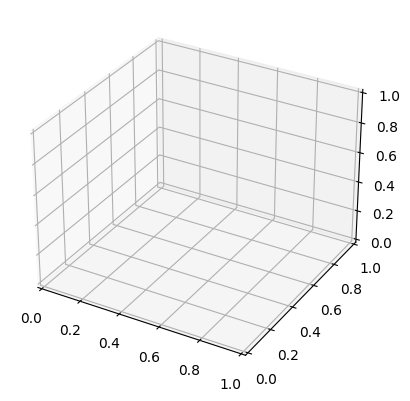

In [4]:
if __name__ == '__main__':
    '''
    Main function to set up optimzer model and run the optimization loop
    '''

    ###========================================================
    ### 1) SET TO GPU OR CPU COMPUTING
    ###========================================================
    if torch.cuda.is_available():
        gpu_or_cpu = torch.device("cuda:0") 
        torch.cuda.set_device(gpu_or_cpu)
    else:
        gpu_or_cpu = torch.device("cpu")

    ###========================================================
    ### 2) VARIABLES FOR BEZIER CURVE CONSTRUCTION
    ###========================================================
    # para_init = torch.tensor([0.02, 0.002, 0.0, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.0])


    # Z axis + 0.1
    # para_init = torch.tensor([0.02, 0.002, 0.1, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.1000])
        
    

    # p_start and para_init used for SRC presentation
    # p_start = torch.tensor([0.02, 0.008, 0.054])
    p_start = torch.tensor([0.02, 0.002, 0.000001]) # 0 here will cause NaN in draw2DCylinderImage, pTip
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0206, -0.0306, 0.1845],
    #                  dtype=np.float32) # 1
    # [ 2.15634587e-02 -6.05764476e-04  5.16317712e-01  1.65068886e-01 -2.39781477e-01  9.49010349e-01]
    para_init = np.array([0.034, -0.01, 0.536, 0.2, -0.37, 0.6],
                     dtype=np.float32)

    # case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/dof2_c48_0.001_-0.005_0.2_0.01'
    case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset3/gt_6_0.0006_-0.0010_0.2_0.01'
    img_save_path = case_naming + '.png'
    cc_specs_path = case_naming + '.npy'
    # cc_specs_path = case_naming + '_gt.npy'
    target_specs_path = None
    viewpoint_mode = 1
    transparent_mode = 0

    '''
    Create binary mask of catheter: 
        1) Grayscale the ref img, 
        2) threshold the grayscaled img, 
        3) Creates a binary image by replacing all 
            pixel values equal to 255 with 1 (leaves
            other pixel values unchanged)
    '''
    # img_ref_rgb = cv2.imread(img_save_path)
    # img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    # (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    img_ref_binary = process_image(img_save_path)

    # Declare loss history lists to keep track of loss values
    proj_end_effector_loss_history = []
    d3d_end_effector_loss_history = []
    # Ground Truth parameters for catheter used in SRC presentation
    # para_gt_np = np.load(cc_specs_path)[1:3, :].flatten()
    para_gt_np = read_gt_params(cc_specs_path)
    # para_gt = torch.tensor([0.02003904, 0.0016096, 0.13205799, 0.00489567, -0.03695673, 0.196168896], dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    para_gt = torch.tensor(para_gt_np, dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    end_effector_gt = para_gt[3:6]


    ###========================================================
    ### 3) SET UP AND RUN OPTIMIZATION MODEL
    ###========================================================
    catheter_optimize_model = CatheterOptimizeModel(p_start, para_init, img_ref_binary, gpu_or_cpu).to(gpu_or_cpu)

    print("Model Parameters:")
    for name, param in catheter_optimize_model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

    optimizer = torch.optim.Adam(catheter_optimize_model.parameters(), lr=1e-2)

    # Run the optimization loop
    num_iterations = 100
    loop = tqdm(range(num_iterations))
    for loop_id in loop:
        print("\n================================================================================================================")
        print("loop_id: ", loop_id)


        # save_img_path = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs/' \
        #     + 'render_' + str(loop_id) + '.jpg'
            
        save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/test_imgs/rendered_imgs_old/' \
            + 'render_' + str(loop_id) + '.jpg'

        # pdb.set_trace()

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Run the forward pass
        loss = catheter_optimize_model(save_img_path)

        # Print gradients for all parameters before backward pass
        print("Gradients BEFORE BACKWARD PASS:")
        for name, param in catheter_optimize_model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")  # Print the norm of the gradient
            else:
                print(f"{name}: No gradient computed")

        # Run the backward pass
        loss.backward(retain_graph=True)

        # Print gradients for all parameters after backward pass
        print("Gradients AFTER BACKWARD PASS:")
        for name, param in catheter_optimize_model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")
            else:
                print(f"{name}: No gradient computed")

        # Update the parameters
        optimizer.step()


        # Print and inspect the updated parameters
        for name, param in catheter_optimize_model.named_parameters():
            print(f"Parameter: {name}, Updated Value: {param.data}")


        # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the progress bar
        loop.set_description('Optimizing')

        # Update the loss
        loop.set_postfix(loss=loss.item())

        print("Loss: ", loss.item())


    # # Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
    # iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
    # print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
    # fig1 = plt.figure()
    # ax1 = fig1.add_subplot(111)
    # fig1.suptitle('2D Tip Euclidean Distance Loss History')
    # ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
    # ax1.set_xlabel('Iterations')
    # ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
    # ax1.set_xlim([0, len(proj_end_effector_loss_history)])
    # ax1.set_ylim([0, 80])
    # ax1.grid(True)
    # plt.show()


    # # Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
    # iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
    # print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
    # fig2 = plt.figure()
    # ax2 = fig2.add_subplot(111)
    # fig2.suptitle('3D Tip Euclidean Distance Loss History')
    # ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
    # ax2.set_xlabel('Iterations')
    # ax2.set_ylabel('Euclidean Distance Loss (m)')
    # ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
    # ax2.set_ylim([0, 0.05])
    # ax2.grid(True)
    # plt.show()

proj_end_effector_loss_history:  [351.2109920910515, 354.58673131073016, 343.0472234082967, 340.82107719984526, 332.08659453999246, 325.9325558319991, 321.0768953595369, 317.0324589964322, 313.7422870600662, 314.5063062036308, 314.2546519711472, 312.1932163751998, 307.2524096321879, 303.0678323371886, 304.29547331340615, 309.28602491602214, 314.04380490580576, 318.50553328961934, 322.6407757485807, 326.46161283457695, 330.2353407288957, 333.47577672310496, 337.0487704345322, 340.3214543340919, 343.2948236191316, 346.5050356384815, 349.33111722317636, 351.63678744527186, 352.9605071382681, 352.38684351495436, 351.43670696405553, 350.2915655915524, 349.0869353734857, 347.8930008432203, 346.9460602625513, 346.6254034062987, 346.2886230011376, 345.8516207702306, 345.45779397954425, 345.38461366529754, 344.2990100125033, 343.33656255411444, 342.048832243821, 340.8427215892415, 339.6688849052687, 338.51245746373064, 337.4065707201074, 336.36375348160743, 335.50809561600573, 334.7347765168379

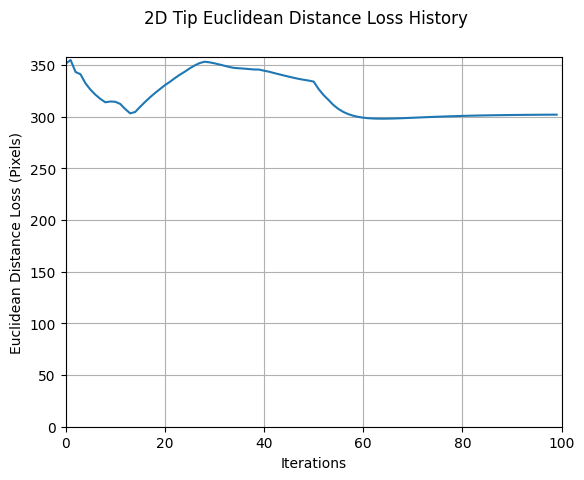

d3d_end_effector_loss_history:  [0.3812606930732727, 0.37374916672706604, 0.37295204401016235, 0.3667472004890442, 0.36218956112861633, 0.3584485650062561, 0.35521379113197327, 0.35248634219169617, 0.3529757559299469, 0.3526415228843689, 0.35082846879959106, 0.3466525077819824, 0.3429965078830719, 0.343720942735672, 0.34750106930732727, 0.3510569632053375, 0.3543471395969391, 0.3573572039604187, 0.36010563373565674, 0.36280423402786255, 0.3650844991207123, 0.3676094114780426, 0.36989790201187134, 0.3719562888145447, 0.3741847276687622, 0.376123309135437, 0.37767863273620605, 0.3785213530063629, 0.37799200415611267, 0.3771962523460388, 0.37626370787620544, 0.3752918541431427, 0.37433141469955444, 0.37355664372444153, 0.3732494115829468, 0.3729361295700073, 0.37255391478538513, 0.3722083866596222, 0.3721048831939697, 0.3712545335292816, 0.37049680948257446, 0.3694973587989807, 0.36855819821357727, 0.36764276027679443, 0.3667398691177368, 0.36587461829185486, 0.3650566339492798, 0.3643805

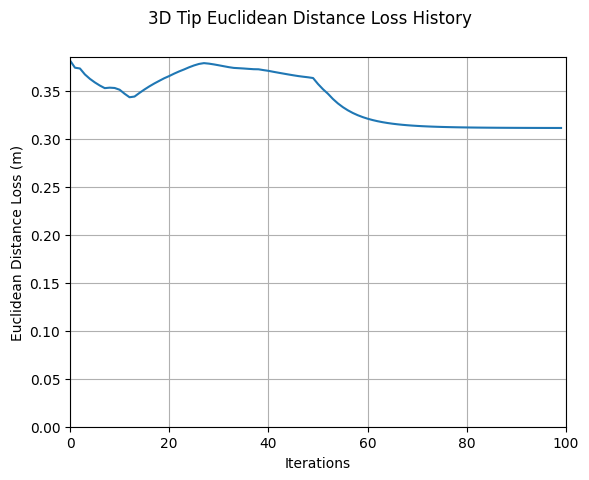

In [5]:
# Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
fig1.suptitle('2D Tip Euclidean Distance Loss History')
ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
ax1.set_xlim([0, len(proj_end_effector_loss_history)])
# ax1.set_ylim([0, 80])
ax1.set_ylim(bottom=0)
ax1.grid(True)
plt.show()


# Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
fig2.suptitle('3D Tip Euclidean Distance Loss History')
ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Euclidean Distance Loss (m)')
ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
ax2.set_ylim(bottom=0)
# ax2.set_ylim([0, 0.05])
ax2.grid(True)
plt.show()

In [7]:
p_start_np = p_start.numpy()
result = catheter_optimize_model.para_init.data.cpu().numpy()
control_points = np.vstack([p_start_np, result.reshape(2, 3)])
control_points_gt = np.vstack([p_start_np, para_gt_np.reshape(2, 3)])
control_points_init = np.vstack([p_start_np, para_init.reshape(2, 3)])

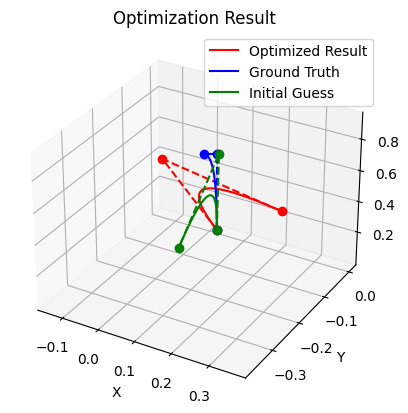

In [8]:
def bezier_curve_3d(control_points, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 3))

    for i in range(num_points):
        curve[i] = (1 - t[i]) ** 2 * control_points[0] + \
                   2 * (1 - t[i]) * t[i] * control_points[1] + \
                   t[i] ** 2 * control_points[2]

    return curve

# Generate the Bezier curve
curve = bezier_curve_3d(control_points)
curve_gt = bezier_curve_3d(control_points_gt)
curve_init = bezier_curve_3d(control_points_init)

# Plotting the Bezier curve
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制第一条贝塞尔曲线及其控制点
ax.plot(control_points[:, 0], control_points[:, 1], control_points[:, 2], 'ro--')
ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], 'r-', label='Optimized Result')

# 绘制第二条贝塞尔曲线及其控制点
ax.plot(control_points_gt[:, 0], control_points_gt[:, 1], control_points_gt[:, 2], 'bo--')
ax.plot(curve_gt[:, 0], curve_gt[:, 1], curve_gt[:, 2], 'b-', label='Ground Truth')

ax.plot(control_points_init[:, 0], control_points_init[:, 1], control_points_init[:, 2], 'go--')
ax.plot(curve_init[:, 0], curve_init[:, 1], curve_init[:, 2], 'g-', label='Initial Guess')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Optimization Result')
ax.legend()

# plt.savefig('Result.png')

plt.show()